# 1-D Plane parallel radiative transfer

All quantities are assumed to be independent of the two horizontal coordinates $x$ and $y$.

The physical quantities are:
* $\rho(z)$ gas density
* $T(\rho)$ gas temperature
* $z$ vertical coordinate above the earth's surface: $z = 0$ top of the atmosphere, $z = z_0 < 0$ bottom of the atmosphere
* $\theta$ observation angle ($\theta = 0$ is looking straight down)

We consider *semi-infinite space* where the gas density is constant if $z <= 0 $ and 0 for $z > 0$, and the extinction function is $ \alpha(z) = \rho(z) \kappa$.

In [1]:
import numpy as np

# default parameters

rho = 1
kappa = 1
B = 1

alpha = rho * kappa

In [2]:
# set up the grid
z0 = -10
Nz = 100
Nmu = 20

z = np.linspace(z0, 0, Nz + 1) # create Nz cell walls
mu = np.linspace(-1, 1, Nmu + 1) # create Nmu cell walls

## Question 1

First of all, we set $\eta = 0$, this way we can directly integrate the FTE:

$$ \mu \frac{dI(z)}{dz} = \alpha(z) [B(z) - I(z)] $$

with $\mu = \cos(\theta)$. Note that $B(z)$ is set to 1 for the test problem here.

In [4]:
# the intensity is now a 2-D array
# remember z runs from z0 to 0
# mu runs from -1 to 1

I = np.zeros((Nz, Nmu))
zero_mu = int(Nmu/2)
I[0, zero_mu:] = B # boundary condition at z = z0, mu > 0
I[-1, 0:zero_mu] = 0 # boundary condition at the top of the atmosphere, mu < 0

h = abs(z0/Nz) # step size

# integrate upwards (mu > 0)
for i in range(1, Nz):
    for j in range(zero_mu, Nmu):
        mu_j = (mu[j + 1] + mu[j])/2 # mu contains Nmu + 1 cell walls
        tau = h * alpha/mu_j # optical depth
        coef1 = (1 - (1 + tau) * np.exp(-tau))/tau
        coef2 = (tau - 1 + np.exp(-tau))/tau

        I[i][j] = I[i-1][j] * np.exp(-tau) + coef1 * B + coef2 * B

# integrate downwards (mu < 0)
for i in range(Nz - 2, -1, -1):
    for j in range(0, zero_mu):
        mu_j = (mu[j + 1] + mu[j])/2
        tau = abs(h * alpha/mu_j) # optical depth
        coef1 = (1 - (1 + tau) * np.exp(-tau))/tau
        coef2 = (tau - 1 + np.exp(-tau))/tau

        I[i][j] = I[i+1][j] * np.exp(-tau) + coef1 * B + coef2 * B

print(I)

[[0.9999702  0.99999126 0.99999815 ... 1.         1.         1.        ]
 [0.99996689 0.99999016 0.99999789 ... 1.         1.         1.        ]
 [0.99996322 0.99998894 0.99999758 ... 1.         1.         1.        ]
 ...
 [0.18984227 0.20966164 0.23407166 ... 1.         1.         1.        ]
 [0.09991237 0.11099023 0.12482668 ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]]


## Question 2

Now we want to compute the mean intensity at every grid point $z_i$ as follows.

$$ J(z) = \frac{1}{2} \int_{-1}^{+1} I(z,\mu) \,d\mu $$

In [5]:
def mean_intensity(z, I, Nmu = 20):
    """
    compute mean intensity with discrete formulation, assuming mu is always from -1 to +1.
    args:
    - z, grid point index
    - I, 2-D array of intensity values at z and mu
    """
    dmu = 2/Nmu
    return 0.5 * sum([I[z][j] * dmu for j in range(Nmu)])

# test
mean_intensity(0, I)

0.9999979673898034

## Question 3

With $\eta = 0.5$, we now need the lambda iteration:
1. Assume $J(z) = 0$, thus $S(z) = (1 - \eta) B(z)$
2. Integrate the FTE $\mu \frac{dI(z)}{dz} = \alpha(z) (S(z) - I(z))$ to get $I(z, \mu)$
3. Compute $J(z)$ using the current $I(z, \mu)$
4. Update the source function using the current mean intensity
5. Repeat step 2 to 4 until the source function converges

In [13]:
eta = 0.5

########
# implement lambda iteration
########

# initialize mean intensity for all grid points
J = np.zeros(Nz)
S_old = np.zeros(Nz)
S = []

# initialize intensity values
I = np.zeros((Nz, Nmu))
zero_mu = int(Nmu/2)
I[0, zero_mu:] = B # boundary condition at z = z0, mu > 0
I[-1, 0:zero_mu] = 0 # boundary condition at the top of the atmosphere, mu < 0

h = abs(z0/Nz) # step size

for i in range(1000):
    # update the source at all grid points
    S_new = (1 - eta) * B + eta * J
    
    S.append(S_new)
    
    if np.mean((S_new - S_old)**2) < 1e-9:
        break
    else:
        S_old = S_new

    # integrate upwards (mu > 0)
    for i in range(1, Nz):
        for j in range(zero_mu, Nmu):
            mu_j = (mu[j + 1] + mu[j])/2 # mu contains Nmu + 1 cell walls
            tau = h * alpha/mu_j # optical depth
            coef1 = (1 - (1 + tau) * np.exp(-tau))/tau
            coef2 = (tau - 1 + np.exp(-tau))/tau

            I[i][j] = I[i-1][j] * np.exp(-tau) + coef1 * S_old[i-1] + coef2 * S_old[i]

    # integrate downwards (mu < 0)
    for i in range(Nz - 2, -1, -1):
        for j in range(0, zero_mu):
            mu_j = (mu[j + 1] + mu[j])/2
            tau = abs(h * alpha/mu_j) # optical depth
            coef1 = (1 - (1 + tau) * np.exp(-tau))/tau
            coef2 = (tau - 1 + np.exp(-tau))/tau

            I[i][j] = I[i+1][j] * np.exp(-tau) + coef1 * S_old[i] + coef2 * S_old[i+1]

    # compute mean intensity at all grid points
    J = np.array([mean_intensity(i, I) for i in range(Nz)])

Text(0.5,1,'Convergence of the source function with # iterations')

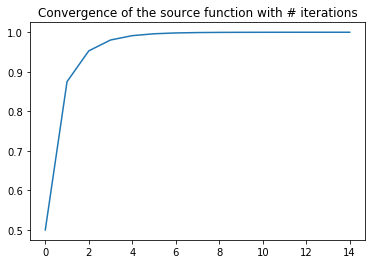

In [23]:
import matplotlib.pyplot as plt

# plot convergence

vals = [s[0] for s in S] # intensity at the bottom of the atmosphere

plt.plot(range(len(vals)), vals)
plt.title("Convergence of the source function with # iterations")

## Question 4

To show that the intensity is declining with increasing $\theta$ (decreasing $\mu$) at the top of the atmosphere.

Text(0.5,1,'Intensity vs mu')

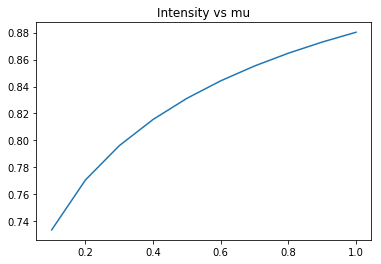

In [31]:
plt.plot(mu[-1:zero_mu:-1], [I[-1][u] for u in range(Nmu-1, zero_mu-1, -1)])
plt.title("Intensity vs mu")